# Dual Augmentation (In-Model, GPU-Native) — Project Intro

## About

**AugmentedModel** is a `tf.keras.Model` wrapper that pushes **image–mask–consistent augmentation into the model graph**, so transforms run **on-GPU** during training (and optionally during evaluation). It also lets you **blend original and augmented batches** per epoch for controlled regularization.

### Why it’s valuable
- **Eliminates the PCIe bottleneck**: only the original batch crosses the bus; all aug ops execute on-GPU.
- **Saves storage**: no need to pre-generate or cache augmented datasets - store originals, synthesize on the fly.
- **Ships with the model**: augmentation/preprocessing can be exported as part of a **SavedModel** for consistent train/eval (eval-time aug is toggleable).
- **Correct class weighting**: **sample weights are computed *after* augmentation** from the transformed masks, matching the distribution the model actually sees.
- **Fast & stable**: compatible with **mixed precision** and **XLA compilation**; avoids Python-side augmentation overhead.
- **Distributed-ready**: cleanly integrates with `tf.distribute.MirroredStrategy` (multi-GPU).
- **Transfer learning friendly**: clear freeze/unfreeze controls and layer visibility for staged fine-tuning.
- **MLOps alignment**: standard Keras callbacks (EarlyStopping/Checkpoint/TensorBoard/MLflow) and reproducible seeding.


### Augmentation Engine (Preprocessing Layers)

The *engine* of this project is a set of **in-graph, GPU-native augmentation layers** that apply **identical random transforms** to images **and** masks (dual mode), guaranteeing label integrity. Geometric ops use **nearest-neighbor** for masks (to preserve class IDs) and **bilinear** for images; all layers are batch-aware and `tf.function`-friendly.

**Geometric (label-preserving; images bilinear, masks nearest)**
- `RandomFlip(mode={'horizontal','vertical','horizontal_and_vertical'})`
- `RandomRotation(angle=[min_deg,max_deg])`
- `RandomShear(shear_angle=[min_deg,max_deg])`
- `RandomZoom(height_factor=(%), width_factor=(%))`
- `RandomJitter(jitter_range=(px_min, px_max))`  ← **spatial jitter (XY translation)**

**Photometric (image-only)**
- `RandomBrightness(factor=[-1..1], image_intensity_range=(min,max))`
- `RandomContrast(factor∈[0..1])`
- `RandomGaussianNoise(stddev=[lo..hi])`

**Cropping**
- `RandomCrop(zoom_factor=%)` – crops a random window then resizes back (no padding mode).
- `CenterCrop(height, width)` – fixed center crop (or resize up if needed).

**Other**
- `SampleWeight(num_classes)` – per-pixel inverse-frequency weights computed **after augmentation**.
- `AffineTransform(rotate, shear, zoom, ...)` – fused geometric transforms.
- `RandomAugmentationLayer(...)` – convenience chain: Flip → Affine → Contrast → Noise → Jitter → Brightness.


**Normalization**
- **Normalize** (`normalize=True`)
  Scales inputs to model’s expected range (e.g., 0–1), keeping masks untouched.

**Training-time weighting**
- **SampleWeight** (`compute_sample_weights=True`)
  Computes **class-aware weights *after augmentation*** from the transformed masks so the loss reflects the *actual* label distribution seen by the model.


*Why in-model:* Eliminates PCIe overhead (ops run on-GPU), saves storage (no pregenerated variants), can be exported with the model, and enables XLA/mixed-precision fusion for speed.




## 1. Import modules

In [1]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf

from callbacks import ResetModelCounter
from layers.augmentation import SampleWeight
from models import AugmentedModel, UNet
from services import ImageAndMaskDatasetBuilder

2025-09-19 04:45:30.732717: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-19 04:45:30.767556: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-19 04:45:30.767600: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-19 04:45:30.767619: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-19 04:45:30.774404: I tensorflow/core/platform/cpu_feature_g

## 2) Data paths & builders

In [2]:
ROOT = os.path.abspath("./assets/images_masks")

train_image_dir = os.path.join(ROOT, 'train', 'images')
train_mask_dir = os.path.join(ROOT, 'train', 'masks')
val_image_dir = os.path.join(ROOT, 'val', 'images')
val_mask_dir = os.path.join(ROOT, 'val', 'masks')
test_image_dir = os.path.join(ROOT, 'test', 'images')
test_mask_dir = os.path.join(ROOT, 'test', 'masks')


In [6]:
final_shape = (1024, 1024)

# Training set
train_data_builder = ImageAndMaskDatasetBuilder(
    images_directory=train_image_dir,
    masks_directory= train_mask_dir,
    image_mask_channels=(3, 1),
    final_image_shape=final_shape,
    batch_size=2,
    return_dict=True,
    image_key='images',
    mask_key='targets',
    split_mask_into_channels=False,
    shuffle_buffer_size=10,
    prefetch_data=True,
    cache_directory='train_cache'
)

train_data_builder.run()
train_ds = train_data_builder.image_mask_dataset
train_ds.element_spec

{'images': TensorSpec(shape=(2, 1024, 1024, 3), dtype=tf.uint8, name=None),
 'targets': TensorSpec(shape=(2, 1024, 1024, 1), dtype=tf.int32, name=None)}

In [7]:
# Validation Set.
val_data_builder = ImageAndMaskDatasetBuilder(
    images_directory=val_image_dir,
    masks_directory= val_mask_dir,
    image_mask_channels=(3, 1),
    final_image_shape=final_shape,
    batch_size=2,
    return_dict=True,
    image_key='images',
    mask_key='targets',
    split_mask_into_channels=False,
    prefetch_data=True,
    cache_directory='val_cache'
)

val_data_builder.run()
val_ds = val_data_builder.image_mask_dataset
val_ds.element_spec

{'images': TensorSpec(shape=(2, 1024, 1024, 3), dtype=tf.uint8, name=None),
 'targets': TensorSpec(shape=(2, 1024, 1024, 1), dtype=tf.int32, name=None)}

### 2c. Sample Weights
Sample weights are computed on the fly, within the model, during training.

In [9]:
layer = SampleWeight(num_classes=4, active=True)
mask = tf.constant([0, 0, 0, 1, 2, 2,2 , 3, 3, 3, 3], dtype=tf.int32, shape=(1, 1, 11, 1))
weights = layer(mask, training=True)
weights

<tf.Tensor: shape=(1, 1, 11, 1), dtype=float32, numpy=
array([[[[0.17391305],
         [0.17391305],
         [0.17391305],
         [0.5217391 ],
         [0.17391305],
         [0.17391305],
         [0.17391305],
         [0.13043478],
         [0.13043478],
         [0.13043478],
         [0.13043478]]]], dtype=float32)>

## 3) Model Build: UNet + transfer learning controls

### 3a) Build models

In [10]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Build UNet
    unet = UNet(num_classes=2,
                input_shape=final_shape + (3,),
                input_name='images',
                output_name='targets',
                post_process=True)

    # Loading saved weights to UNet model.
    unet.load_weights("./saved_models/unet/subclassed_unet_no_pp_1024x1024.keras")

    # Build AugmentedModel
    aug_model = AugmentedModel(base_model=unet,
                               num_of_classes=2,
                               image_key=train_data_builder.image_key,
                               target_key=train_data_builder.mask_key,
                               batches_before_aug=19,
                               augment_on_eval=True,
                               compute_sample_weights=True,
                               flip=True,
                               flip_mode='Horizontal_and_vertical',
                               rotate=True,
                               theta= (-45, 45),
                               shear=False,
                               shear_angle=(-45, 45),
                               zoom=True,
                               zoom_factor=(0, 100),
                               use_gaussian_noise=False,
                               gaussian_range=5.0,
                               adjust_brightness=False,
                               brightness_range=(0, 0.1),
                               adjust_contrast=True,
                               contrast_range=(0.0, 1.0),
                               jitter=False,
                               jitter_range=(0, 60),
                               normalize=True,
                               )

    # compile model
    aug_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=[
                      tf.keras.metrics.MeanIoU(num_classes=aug_model.num_of_classes,
                                               name='MIoU',
                                               sparse_y_pred=False,
                                               sparse_y_true=False)
                  ])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


### 3b. Preview Augmentation Settings

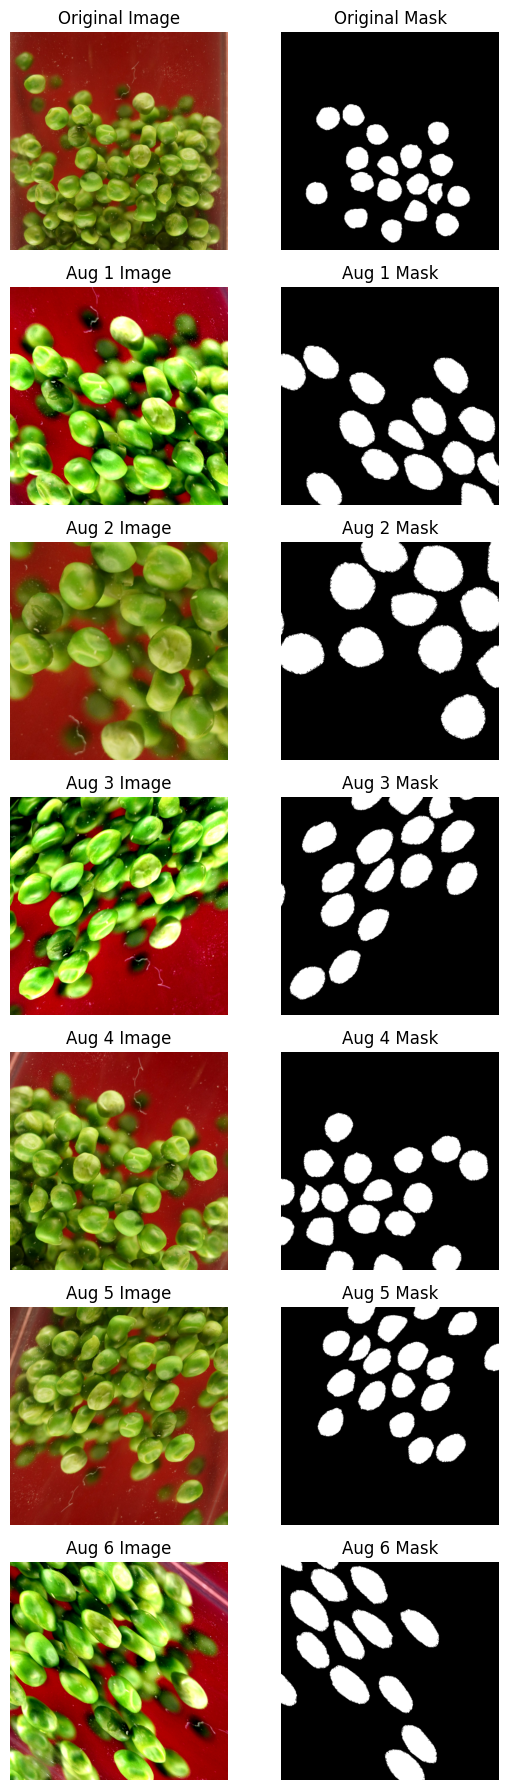

In [11]:
aug_model.preview_augmentation()

### 3c) Preview trainable status of the model layers
No frozen layer

In [12]:
unet.view_trainable_status()



----------------UNET LAYER STATUS---------------- 
INDEX  LAYER_NAME                  TRAINABLE LAYER
0.     conv1_encod_blk_1           True
1.     conv2_encod_blk_1           True
2.     relu_encod_blk_1            True
3.     maxpool_encod_blk_1         True
4.     dropout_encod_blk_1         True
5.     conv1_encod_blk_2           True
6.     conv2_encod_blk_2           True
7.     relu_encod_blk_2            True
8.     maxpool_encod_blk_2         True
9.     dropout_encod_blk_2         True
10.    conv1_encod_blk_3           True
11.    conv2_encod_blk_3           True
12.    relu_encod_blk_3            True
13.    maxpool_encod_blk_3         True
14.    dropout_encod_blk_3         True
15.    conv1_encod_blk_4           True
16.    conv2_encod_blk_4           True
17.    relu_encod_blk_4            True
18.    maxpool_encod_blk_4         True
19.    dropout_encod_blk_4         True
20.    conv1_bottle_neck           True
21.    conv2_bottle_neck           True
22.    relu_bott

Let us freeze some layers

In [13]:
layers_to_freeze =['conv1_encod_blk_1',
                   'conv2_encod_blk_1',
                   'relu_encod_blk_1',
                   'maxpool_encod_blk_1',
                   'dropout_encod_blk_1',
                   'conv1_encod_blk_2']

# Freeze layer by name.
unet.freeze_layers(layers=layers_to_freeze)     # Layers can also be frozen by the position of the layers  with the model (e.g., [9, 10, 23, 67, 89])

# View layer status
unet.view_trainable_status()



----------------UNET LAYER STATUS---------------- 
INDEX  LAYER_NAME                  TRAINABLE LAYER
0.     conv1_encod_blk_1           False
1.     conv2_encod_blk_1           False
2.     relu_encod_blk_1            False
3.     maxpool_encod_blk_1         False
4.     dropout_encod_blk_1         False
5.     conv1_encod_blk_2           False
6.     conv2_encod_blk_2           True
7.     relu_encod_blk_2            True
8.     maxpool_encod_blk_2         True
9.     dropout_encod_blk_2         True
10.    conv1_encod_blk_3           True
11.    conv2_encod_blk_3           True
12.    relu_encod_blk_3            True
13.    maxpool_encod_blk_3         True
14.    dropout_encod_blk_3         True
15.    conv1_encod_blk_4           True
16.    conv2_encod_blk_4           True
17.    relu_encod_blk_4            True
18.    maxpool_encod_blk_4         True
19.    dropout_encod_blk_4         True
20.    conv1_bottle_neck           True
21.    conv2_bottle_neck           True
22.    rel

Make the frozen layers trainable

In [14]:
unet.freeze_layers()
unet.view_trainable_status()



----------------UNET LAYER STATUS---------------- 
INDEX  LAYER_NAME                  TRAINABLE LAYER
0.     conv1_encod_blk_1           True
1.     conv2_encod_blk_1           True
2.     relu_encod_blk_1            True
3.     maxpool_encod_blk_1         True
4.     dropout_encod_blk_1         True
5.     conv1_encod_blk_2           True
6.     conv2_encod_blk_2           True
7.     relu_encod_blk_2            True
8.     maxpool_encod_blk_2         True
9.     dropout_encod_blk_2         True
10.    conv1_encod_blk_3           True
11.    conv2_encod_blk_3           True
12.    relu_encod_blk_3            True
13.    maxpool_encod_blk_3         True
14.    dropout_encod_blk_3         True
15.    conv1_encod_blk_4           True
16.    conv2_encod_blk_4           True
17.    relu_encod_blk_4            True
18.    maxpool_encod_blk_4         True
19.    dropout_encod_blk_4         True
20.    conv1_bottle_neck           True
21.    conv2_bottle_neck           True
22.    relu_bott

## 4) Training + ResetModel Counter callback

In [ ]:
# With ResetModelCounter,during each epoch, the model is able to learn from a specified number of original dataset, before augmentation kicks in.
reset_counter = ResetModelCounter()

aug_model.fit(train_ds, epochs=30,
              steps_per_epoch=500, validation_data=val_ds,
              validation_steps=20, callbacks=[reset_counter])

## 6) Segmentation demo

2025-09-19 04:49:02.590072: W tensorflow/core/kernels/data/cache_dataset_ops.cc:298] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-09-19 04:49:02.749021: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2025-09-19 04:49:03.119073: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-09-19 04:49:17.403133: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-09-19 04:

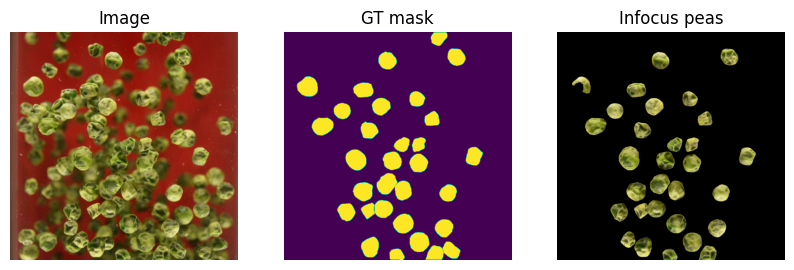

In [15]:
batch = next(iter(val_ds.take(1)))
img  = tf.cast(batch['images'][0], tf.float32) / 255.0
pred = aug_model.base_model(tf.expand_dims(img, 0), training=False)  # [1,H,W,C]
out = unet.segment({'images': img[tf.newaxis, ...]})

plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.imshow(tf.cast(batch['images'][0], tf.uint8)); plt.title("Image"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(tf.squeeze(batch['targets'][0])); plt.title("GT mask"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(out['infocus_peas'][0]); plt.title("Infocus peas"); plt.axis("off")
plt.show()

In [16]:
# Return TF module version of the model (AugmentedModel + UNet)
tf_module = unet.tf_module
mask = tf_module.segment(img[tf.newaxis, ...])
mask = tf.argmax(mask['infocus_peas'], axis=-1)
mask

<tf.Tensor: shape=(1, 1024, 1024), dtype=int64, numpy=
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])>

## 7) Evaluate Model

In [16]:
aug_model.evaluate(val_ds, steps=5)


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2025-09-19 03:25:28.045603: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.77GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-09-19 03:25:29.844880: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-09-19 03:25:30.000665: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-09-19 03:25:31.872796: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU

2/5 [===========>..................] - ETA: 6s - loss: 0.3090 - MIoU: 0.8684  

2025-09-19 03:26:21.045777: W tensorflow/core/kernels/data/cache_dataset_ops.cc:298] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


5/5 [==============================] - ETA: 0s - loss: 0.2643 - MIoU: 0.8693INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
5/5 [==============================] - 69s 2s/step - loss: 0.2643 - MIoU: 0.8693


[0.2642882764339447, 0.8692545890808105]

## 8) Export for serving

In [17]:
# SavedModel export:
aug_model.base_model.save("./saved_models/aug_model/unet_seg_savedmodel")
# or just the UNet if you prefer


INFO:tensorflow:Assets written to: ./saved_models/aug_model/unet_seg_savedmodel/assets


INFO:tensorflow:Assets written to: ./saved_models/aug_model/unet_seg_savedmodel/assets
